In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import seaborn as sns
import joblib
from tqdm.notebook import tqdm 
import warnings

In [115]:
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [117]:
def load_multiple_subjects(data_path, subjects=None):
    """
    Charge les données NinaPro pour le premier exercice (12 mouvements) à partir de fichiers .mat
    pour plusieurs sujets.

    Args:
        data_path: Chemin vers le répertoire contenant les fichiers .mat
        subjects: Liste des IDs de sujet (entiers) à charger (None pour tous les sujets disponibles)

    Returns:
        all_emg_data: Liste des données EMG pour chaque sujet
        all_labels: Liste des étiquettes pour chaque sujet
        subject_ids: Liste des IDs de sujet correspondants
    """
    print("Chargement des données pour plusieurs sujets...")
    mat_files_pattern = os.path.join(data_path, "S*_A1_E1.mat")
    mat_files = glob.glob(mat_files_pattern)
    print(f"Recherche avec le pattern: {mat_files_pattern}")
    print(f"Fichiers trouvés: {len(mat_files)}")

    if not mat_files:
        print(f"AVERTISSEMENT: Aucun fichier .mat trouvé dans {data_path} correspondant au pattern S*_A1_E1.mat.")
        print("Vérifiez le chemin 'data_path' et la structure des fichiers.")
        return [], [], []

    filtered_mat_files = []
    if subjects is not None:
        subject_set = set(subjects)
        for f in mat_files:
            try:
                basename = os.path.basename(f)
                subject_id_str = basename.split('_')[0][1:]
                subject_id = int(subject_id_str)
                if subject_id in subject_set:
                    filtered_mat_files.append(f)
            except (IndexError, ValueError):
                print(f"Impossible d'extraire l'ID du sujet du fichier: {f}")
        mat_files = filtered_mat_files
        print(f"Fichiers filtrés pour les sujets {subjects}: {len(mat_files)}")
    else:
         print("Chargement de tous les sujets trouvés.")


    all_emg_data = []
    all_labels = []
    subject_ids_loaded = []

    mat_files.sort(key=lambda f: int(os.path.basename(f).split('_')[0][1:]))

    for mat_file in tqdm(mat_files, desc="Chargement des sujets"):
        try:
            basename = os.path.basename(mat_file)
            subject_id = int(basename.split('_')[0][1:])

            data = loadmat(mat_file)

            if 'emg' in data:
                emg_data = data['emg']
            else:
                print(f"Clé 'emg' non trouvée dans {mat_file}. Clés disponibles: {data.keys()}")
                continue 

            if 'restimulus' in data:
                labels = data['restimulus'].flatten()
            elif 'stimulus' in data:
                print(f"Utilisation de 'stimulus' comme étiquettes pour {mat_file} (peut exclure la classe repos).")
                labels = data['stimulus'].flatten()
            else:
                 print(f"Clés 'restimulus' ou 'stimulus' non trouvées dans {mat_file}. Clés disponibles: {data.keys()}")
                 continue 

            if emg_data.shape[0] != labels.shape[0]:
                print(f"Erreur de forme pour Sujet {subject_id}: EMG {emg_data.shape[0]} échantillons, Labels {labels.shape[0]} échantillons. Alignement nécessaire.")
                min_len = min(emg_data.shape[0], labels.shape[0])
                emg_data = emg_data[:min_len, :]
                labels = labels[:min_len]
                print(f"  Formes alignées à {min_len} échantillons.")

            all_emg_data.append(emg_data)
            all_labels.append(labels)
            subject_ids_loaded.append(subject_id)


        except Exception as e:
            print(f"Erreur lors du chargement ou du traitement du fichier {mat_file}: {e}")

    print(f"Données chargées pour {len(all_emg_data)} sujets: {subject_ids_loaded}")
    return all_emg_data, all_labels, subject_ids_loaded


In [119]:
def extract_features(emg_data, window_size=200, overlap=100):
    """
    Extrait les descripteurs temporels à partir des signaux EMG en utilisant une fenêtre glissante.

    Args:
        emg_data: Données EMG (échantillons x canaux)
        window_size: Taille de la fenêtre en échantillons
        overlap: Chevauchement entre les fenêtres en échantillons

    Returns:
        features: Matrice de descripteurs (n_windows x (n_channels * n_features_per_channel))
    """
    if emg_data.ndim == 1: 
        emg_data = emg_data.reshape(-1, 1)

    n_samples, n_channels = emg_data.shape
    step = window_size - overlap


    if step <= 0:
        raise ValueError("La taille de la fenêtre doit être supérieure au chevauchement.")
    n_windows = (n_samples - window_size) // step + 1

    if n_windows <= 0:
        return np.empty((0, n_channels * 5)) 

    n_features_per_channel = 5  
    features = np.zeros((n_windows, n_channels * n_features_per_channel))

    for w in range(n_windows):
        start = w * step
        end = start + window_size
        window = emg_data[start:end, :]

        feature_col_idx = 0 
        for c in range(n_channels):
            channel_data = window[:, c]

            if np.all(channel_data == channel_data[0]):
                 mav = np.abs(channel_data[0])
                 rms = np.abs(channel_data[0])
                 wl = 0.0
                 zc = 0.0
                 ssc = 0.0
            else:
                mav = np.mean(np.abs(channel_data))

                rms = np.sqrt(np.mean(np.square(channel_data)))

                wl = np.sum(np.abs(np.diff(channel_data)))

                threshold = 1e-5 
                zc = np.sum(((channel_data[:-1] * channel_data[1:]) < 0) & (np.abs(channel_data[:-1] - channel_data[1:]) > threshold))

                diff_signal = np.diff(channel_data)
                ssc = np.sum(((diff_signal[:-1] * diff_signal[1:]) < 0) & (np.abs(diff_signal[:-1]) > threshold) & (np.abs(diff_signal[1:]) > threshold))


            features[w, feature_col_idx : feature_col_idx + n_features_per_channel] = [mav, rms, wl, zc, ssc]
            feature_col_idx += n_features_per_channel

    return features

In [121]:
def segment_data(emg_data, labels, window_size=200, overlap=100):
    """
    Segmente les données EMG en fenêtres, extrait les descripteurs pour chaque fenêtre,
    et associe chaque fenêtre à une étiquette (étiquette majoritaire dans la fenêtre).

    Args:
        emg_data: Données EMG (échantillons x canaux)
        labels: Étiquettes des classes (1D array, longueur = n_samples)
        window_size: Taille de la fenêtre d'analyse
        overlap: Chevauchement entre les fenêtres

    Returns:
        segmented_features: Descripteurs pour chaque segment (fenêtre)
        segmented_labels: Étiquettes pour chaque segment (fenêtre)
    """
    features = extract_features(emg_data, window_size, overlap)

    if features.shape[0] == 0:
        return np.empty((0, features.shape[1])), np.empty((0,), dtype=int)


    step = window_size - overlap
    n_windows = features.shape[0]

    segmented_labels = np.zeros(n_windows, dtype=int)

    for w in range(n_windows):
        start = w * step
        end = start + window_size
        window_labels = labels[start:end]

        if len(window_labels) == 0:
             print(f"Avertissement: Fenêtre {w} vide pour les étiquettes.")
             segmented_labels[w] = 0 
             continue


        unique_labels, counts = np.unique(window_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(counts)]
        segmented_labels[w] = majority_label

    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

    return features, segmented_labels

In [123]:
def preprocess_all_subjects(all_emg_data, all_labels, subject_ids, window_size=200, overlap=100):
    """
    Prétraite les données de tous les sujets en segmentant et extrayant les descripteurs.

    Args:
        all_emg_data: Liste des données EMG pour chaque sujet
        all_labels: Liste des étiquettes pour chaque sujet
        subject_ids: Liste des IDs de sujet correspondants
        window_size: Taille de la fenêtre d'analyse
        overlap: Chevauchement entre les fenêtres

    Returns:
        all_features: Liste des descripteurs pour chaque sujet
        all_segmented_labels: Liste des étiquettes segmentées pour chaque sujet
        valid_subject_ids: Liste des IDs de sujets pour lesquels le prétraitement a réussi
    """
    print("Prétraitement des données pour tous les sujets...")

    all_features = []
    all_segmented_labels = []
    valid_subject_ids = []

    iterator = tqdm(zip(all_emg_data, all_labels, subject_ids),
                    desc="Prétraitement des sujets",
                    total=len(all_emg_data))

    for emg_data, labels, subj_id in iterator:
        iterator.set_description(f"Prétraitement Sujet {subj_id}")

        features, segmented_labels = segment_data(emg_data, labels, window_size, overlap)

        if features.shape[0] > 0:
            if features.shape[0] > 0:
                all_features.append(features)
                all_segmented_labels.append(segmented_labels)
                valid_subject_ids.append(subj_id)
            else:
                 print(f"Sujet {subj_id}: Aucune donnée valide après filtrage (ou données initiales trop courtes).")

        else:
             print(f"Sujet {subj_id}: Aucune feature extraite (données initiales probablement trop courtes).")


    print(f"Prétraitement terminé pour {len(valid_subject_ids)} sujets.")
    return all_features, all_segmented_labels, valid_subject_ids

In [125]:
def combine_data(all_features, all_segmented_labels, test_size=0.3, random_state=42):
    """
    Combine les données de tous les sujets, les normalise et les divise
    en ensembles d'entraînement et de test.

    Args:
        all_features: Liste des descripteurs pour chaque sujet.
        all_segmented_labels: Liste des étiquettes segmentées pour chaque sujet.
        test_size: Proportion des données à utiliser pour le test.
        random_state: Graine aléatoire pour la reproductibilité.

    Returns:
        X_train, X_test, y_train, y_test: Ensembles de données divisés et normalisés.
        scaler: L'objet StandardScaler ajusté sur les données d'entraînement.
    """
    print("Combinaison et préparation des données...")

    if not all_features or not all_segmented_labels:
        print("Erreur: Les listes de features ou d'étiquettes sont vides. Impossible de combiner.")
        return None, None, None, None, None

    try:
        X = np.vstack(all_features)
        y = np.hstack(all_segmented_labels)
    except ValueError as e:
        print(f"Erreur lors de la concaténation des données: {e}")
        print("Cela peut se produire si les features de différents sujets n'ont pas le même nombre de colonnes.")
        return None, None, None, None, None


    print(f"Données combinées: X shape={X.shape}, y shape={y.shape}")
    classes, counts = np.unique(y, return_counts=True)
    print(f"Classes présentes: {classes}")
    print(f"Nombre d'échantillons par classe: {counts}")

    if X.shape[0] < 2 or len(classes) < 2:
        print("Erreur: Pas assez de données ou de classes pour effectuer une division train/test.")
        return None, None, None, None, None

    min_samples_per_class = max(2, int(np.ceil(1/test_size))) if test_size > 0 else 2
    if test_size > 0 and np.any(counts < min_samples_per_class):
         print(f"Avertissement: Certaines classes ont moins de {min_samples_per_class} échantillons. La stratification peut échouer ou être inefficace.")
         stratify_option = None
    elif test_size == 0:
        stratify_option = None 
    else:
         stratify_option = y


    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=stratify_option
        )
    else:
        X_train, X_test, y_train, y_test = X, np.array([]), y, np.array([])
        print("Utilisation de toutes les données pour l'entraînement (test_size=0).")



    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    print(f"Données d'entraînement: {X_train_scaled.shape}, Étiquettes d'entraînement: {y_train.shape}")

    if X_test.shape[0] > 0:
        X_test_scaled = scaler.transform(X_test)
        print(f"Données de test: {X_test_scaled.shape}, Étiquettes de test: {y_test.shape}")
    else:
        X_test_scaled = np.array([]) 

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [127]:
def train_xgboost_model(X_train, y_train):
    """
    Entraîne un modèle XGBoost sur les données d'entraînement.

    Args:
        X_train: Descripteurs d'entraînement normalisés.
        y_train: Étiquettes d'entraînement.

    Returns:
        model: Modèle XGBoost entraîné.
        num_classes: Nombre de classes détectées.
    """
    print("Entraînement du modèle XGBoost...")

    unique_labels = np.unique(y_train)
    num_classes = len(unique_labels)
    print(f"Nombre de classes détectées dans y_train: {num_classes} (Étiquettes: {unique_labels})")


    if unique_labels.min() > 0:
        print("Ajustement des étiquettes pour commencer à 0...")
        label_map = {label: i for i, label in enumerate(unique_labels)}
        y_train_mapped = np.array([label_map[label] for label in y_train])
        print(f"Nouvelles étiquettes mappées: {np.unique(y_train_mapped)}")
    else:
        y_train_mapped = y_train 

    params = {
        'objective': 'multi:softmax', 
        'num_class': num_classes,      
        'learning_rate': 0.1,          
        'max_depth': 6,                
        'n_estimators': 200,           
        'subsample': 0.8,              
        'colsample_bytree': 0.8,       
        'gamma': 0.1,                  
        'random_state': 42,            
        'n_jobs': -1                   
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train_mapped) 

    print("Entraînement terminé!")
    label_map_inverse = {v: k for k, v in label_map.items()} if 'label_map' in locals() else None

    return model, num_classes, label_map_inverse 

In [129]:
def evaluate_model(model, X_test, y_test, label_map_inverse=None, save_plots=True):
    """
    Évalue les performances du modèle sur l'ensemble de test.

    Args:
        model: Modèle XGBoost entraîné.
        X_test: Descripteurs de test normalisés.
        y_test: Étiquettes de test réelles.
        label_map_inverse: Dictionnaire pour mapper les prédictions (0..N-1) aux étiquettes originales, si nécessaire.
        save_plots: Booléen pour sauvegarder les graphiques générés.

    Returns:
        accuracy: Précision globale.
        conf_matrix: Matrice de confusion.
        y_pred: Prédictions du modèle sur X_test.
    """
    print("Évaluation du modèle...")

    if X_test.shape[0] == 0:
        print("Aucune donnée de test fournie. Évaluation impossible.")
        return 0.0, None, None

    y_pred_mapped = model.predict(X_test)

    if label_map_inverse:
        y_pred = np.array([label_map_inverse[pred] for pred in y_pred_mapped])
        y_test_original = y_test 
        print("Utilisation du mapping inverse pour afficher les étiquettes originales.")
        target_names = [str(label) for label in sorted(label_map_inverse.values())] 
    else:
        y_pred = y_pred_mapped
        y_test_original = y_test
        target_names = [str(label) for label in sorted(np.unique(y_test_original))] 

    accuracy = accuracy_score(y_test_original, y_pred)
    conf_matrix = confusion_matrix(y_test_original, y_pred)

    print(f"Précision du modèle sur l'ensemble de test: {accuracy:.4f}")

    print("\nMatrice de confusion:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.title('Matrice de Confusion')
    if save_plots:
        plt.savefig('confusion_matrix.png')
        print("Matrice de confusion sauvegardée: confusion_matrix.png")
    plt.show()
    plt.close()

    print("\nRapport de classification:")
    report = classification_report(y_test_original, y_pred, target_names=target_names)
    print(report)

    print("\nImportance des descripteurs (Top 20):")
    try:
        feature_importance = model.feature_importances_
        n_channels = X_test.shape[1] // 5 
        feature_names = []
        feature_types = ['MAV', 'RMS', 'WL', 'ZC', 'SSC']
        for c in range(n_channels):
            for f_type in feature_types:
                feature_names.append(f'C{c+1}_{f_type}')

        if len(feature_names) != len(feature_importance):
             print(f"Avertissement: Nombre de noms de features ({len(feature_names)}) différent de l'importance ({len(feature_importance)}). Utilisation de noms génériques.")
             feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]


        sorted_idx = np.argsort(feature_importance)[-20:] 

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.xlabel('Importance (Gain)')
        plt.title('Importance des descripteurs XGBoost (Top 20)')
        plt.tight_layout()
        if save_plots:
            plt.savefig('feature_importance.png')
            print("Graphique d'importance des descripteurs sauvegardé: feature_importance.png")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Impossible de générer le graphique d'importance des descripteurs: {e}")


    try:
        report_dict = classification_report(y_test_original, y_pred, target_names=target_names, output_dict=True)
        class_labels = [label for label in report_dict.keys() if label not in ('accuracy', 'macro avg', 'weighted avg')]
        class_precision = [report_dict[label]['precision'] for label in class_labels]
        class_recall = [report_dict[label]['recall'] for label in class_labels]

        x = np.arange(len(class_labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))
        rects1 = ax.bar(x - width/2, class_precision, width, label='Précision')
        rects2 = ax.bar(x + width/2, class_recall, width, label='Rappel (Recall)')

        ax.set_ylabel('Score')
        ax.set_title('Précision et Rappel par Classe')
        ax.set_xticks(x)
        ax.set_xticklabels(class_labels)
        ax.set_xlabel('Classe')
        ax.legend()
        ax.bar_label(rects1, padding=3, fmt='%.2f')
        ax.bar_label(rects2, padding=3, fmt='%.2f')
        fig.tight_layout()

        if save_plots:
            plt.savefig('class_performance.png')
            print("Graphique de performance par classe sauvegardé: class_performance.png")
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Impossible de générer le graphique de performance par classe: {e}")


    return accuracy, conf_matrix, y_pred

In [131]:
def cross_validate_model(X_scaled, y, n_splits=5, random_state=42):
    """
    Effectue une validation croisée Stratified K-Fold pour évaluer la robustesse du modèle XGBoost.

    Args:
        X_scaled: Ensemble complet des descripteurs normalisés.
        y: Ensemble complet des étiquettes correspondantes.
        n_splits: Nombre de plis pour la validation croisée.
        random_state: Graine aléatoire pour la reproductibilité.

    Returns:
        cv_scores: Liste des scores de précision pour chaque pli.
    """
    print(f"\nValidation croisée ({n_splits} plis)...")

    unique_labels_cv = np.unique(y)
    num_classes_cv = len(unique_labels_cv)
    y_mapped_cv = y
    label_map_cv = None
    if unique_labels_cv.min() > 0:
        print("Ajustement des étiquettes pour CV...")
        label_map_cv = {label: i for i, label in enumerate(unique_labels_cv)}
        y_mapped_cv = np.array([label_map_cv[label] for label in y])

    params = {
        'objective': 'multi:softmax', 'num_class': num_classes_cv,
        'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200,
        'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1,
        'random_state': random_state, 'n_jobs': -1
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = []
    conf_matrix_cv_sum = np.zeros((num_classes_cv, num_classes_cv), dtype=int)

    for i, (train_idx, test_idx) in enumerate(tqdm(skf.split(X_scaled, y_mapped_cv), total=n_splits, desc="CV Folds")):
        X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
        y_train_fold, y_test_fold = y_mapped_cv[train_idx], y_mapped_cv[test_idx]

        model_fold = xgb.XGBClassifier(**params)
        model_fold.fit(X_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict(X_test_fold)
        accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
        cv_scores.append(accuracy_fold)

        conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold, labels=np.arange(num_classes_cv))
        if conf_matrix_fold.shape == conf_matrix_cv_sum.shape:
             conf_matrix_cv_sum += conf_matrix_fold
        else:
            print(f"Avertissement: Taille de matrice de confusion inattendue dans le pli {i+1}. Attendue {conf_matrix_cv_sum.shape}, obtenue {conf_matrix_fold.shape}")



    mean_accuracy = np.mean(cv_scores)
    std_accuracy = np.std(cv_scores)
    print(f"\nPrécision moyenne de la validation croisée ({n_splits} plis): {mean_accuracy:.4f} ± {std_accuracy:.4f}")

    print("\nMatrice de confusion cumulée de la validation croisée:")
    plt.figure(figsize=(10, 8))
    target_names_cv = [str(label_map_cv[i]) if label_map_cv else str(i) for i in range(num_classes_cv)]
    sns.heatmap(conf_matrix_cv_sum, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_cv, yticklabels=target_names_cv)
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.title(f'Matrice de Confusion Cumulée (CV {n_splits} plis)')
    plt.savefig('confusion_matrix_cv.png')
    print("Matrice de confusion CV sauvegardée: confusion_matrix_cv.png")
    plt.show()
    plt.close()


    return cv_scores

In [133]:
def predict_new_sample(new_emg_data, model, scaler, window_size=200, label_map_inverse=None):
    """
    Prédit la classe d'un ou plusieurs segments d'un nouveau signal EMG.

    Args:
        new_emg_data: Nouveau signal EMG (échantillons x canaux). Doit avoir au moins `window_size` échantillons.
        model: Modèle XGBoost entraîné.
        scaler: Scaler StandardScaler ajusté.
        window_size: Taille de la fenêtre utilisée pour l'extraction des features (doit correspondre à l'entraînement).
        label_map_inverse: Dictionnaire pour mapper les prédictions (0..N-1) aux étiquettes originales.

    Returns:
        predictions: Array des classes prédites pour chaque fenêtre extraite du signal.
                     Retourne None en cas d'erreur ou de données insuffisantes.
    """
    print("\nPrédiction sur un nouvel échantillon...")
    if new_emg_data.shape[0] < window_size:
        print(f"Erreur: Les nouvelles données EMG (longueur {new_emg_data.shape[0]}) sont plus courtes que la taille de fenêtre ({window_size}).")
        return None


    overlap_predict = 0 
    try:
        new_features = extract_features(new_emg_data, window_size=window_size, overlap=overlap_predict)
        if new_features.shape[0] == 0:
             print("Aucune feature n'a pu être extraite du nouvel échantillon.")
             return None
    except Exception as e:
        print(f"Erreur lors de l'extraction des features du nouvel échantillon: {e}")
        return None
        
    try:
        new_features_scaled = scaler.transform(new_features)
    except Exception as e:
        print(f"Erreur lors de la normalisation des features du nouvel échantillon: {e}")
        return None

    try:
        predictions_mapped = model.predict(new_features_scaled)
    except Exception as e:
        print(f"Erreur lors de la prédiction avec le modèle: {e}")
        return None


    if label_map_inverse:
        try:
            predictions = np.array([label_map_inverse[pred] for pred in predictions_mapped])
        except KeyError as e:
             print(f"Erreur de mapping: La prédiction {e} n'est pas dans le dictionnaire de mapping inverse.")
             predictions = predictions_mapped 
    else:
        predictions = predictions_mapped

    print(f"Prédictions pour les {predictions.shape[0]} fenêtres extraites: {predictions}")
    return predictions

--- Début du script de classification EMG avec XGBoost ---
Chargement des données pour plusieurs sujets...
Recherche avec le pattern: /kaggle/input/ninapro-dataset/S*_A1_E1.mat
Fichiers trouvés: 19
Chargement de tous les sujets trouvés.


Chargement des sujets:   0%|          | 0/19 [00:00<?, ?it/s]

Données chargées pour 19 sujets: [1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 17, 18, 19, 21, 23, 24, 25, 26, 27]
Prétraitement des données pour tous les sujets...


Prétraitement des sujets:   0%|          | 0/19 [00:00<?, ?it/s]

Prétraitement terminé pour 19 sujets.
Combinaison et préparation des données...
Données combinées: X shape=(19189, 50), y shape=(19189,)
Classes présentes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Nombre d'échantillons par classe: [10774   731   727   803   684   696   717   696   733   674   667   607
   680]
Données d'entraînement: (14391, 50), Étiquettes d'entraînement: (14391,)
Données de test: (4798, 50), Étiquettes de test: (4798,)
Entraînement du modèle XGBoost...
Nombre de classes détectées dans y_train: 13 (Étiquettes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12])
Entraînement terminé!
Évaluation du modèle...
Précision du modèle sur l'ensemble de test: 0.8283

Matrice de confusion:
Matrice de confusion sauvegardée: confusion_matrix.png


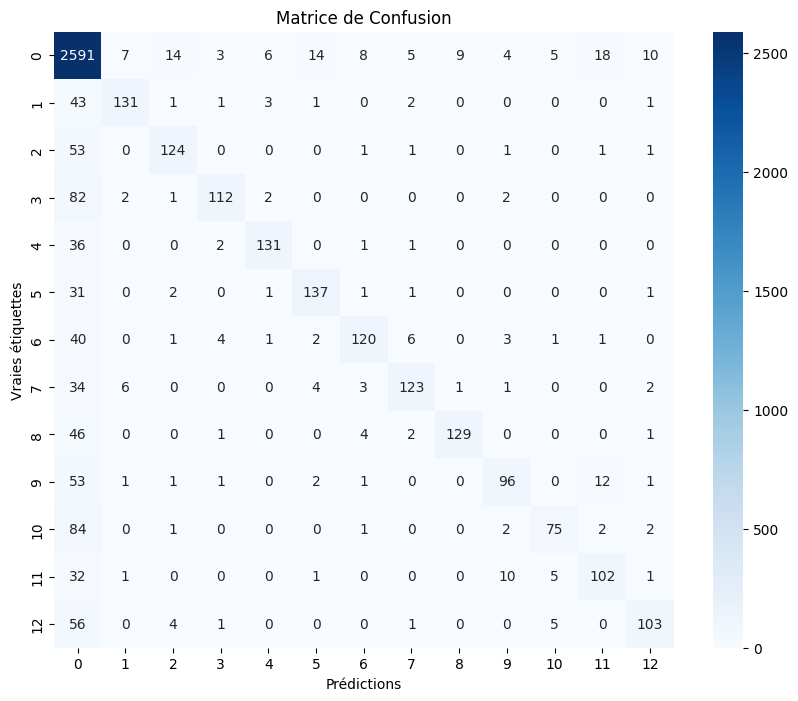


Rapport de classification:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2694
           1       0.89      0.72      0.79       183
           2       0.83      0.68      0.75       182
           3       0.90      0.56      0.69       201
           4       0.91      0.77      0.83       171
           5       0.85      0.79      0.82       174
           6       0.86      0.67      0.75       179
           7       0.87      0.71      0.78       174
           8       0.93      0.70      0.80       183
           9       0.81      0.57      0.67       168
          10       0.82      0.45      0.58       167
          11       0.75      0.67      0.71       152
          12       0.84      0.61      0.70       170

    accuracy                           0.83      4798
   macro avg       0.85      0.68      0.75      4798
weighted avg       0.83      0.83      0.82      4798


Importance des descripteurs (Top 20):
Graphique d'

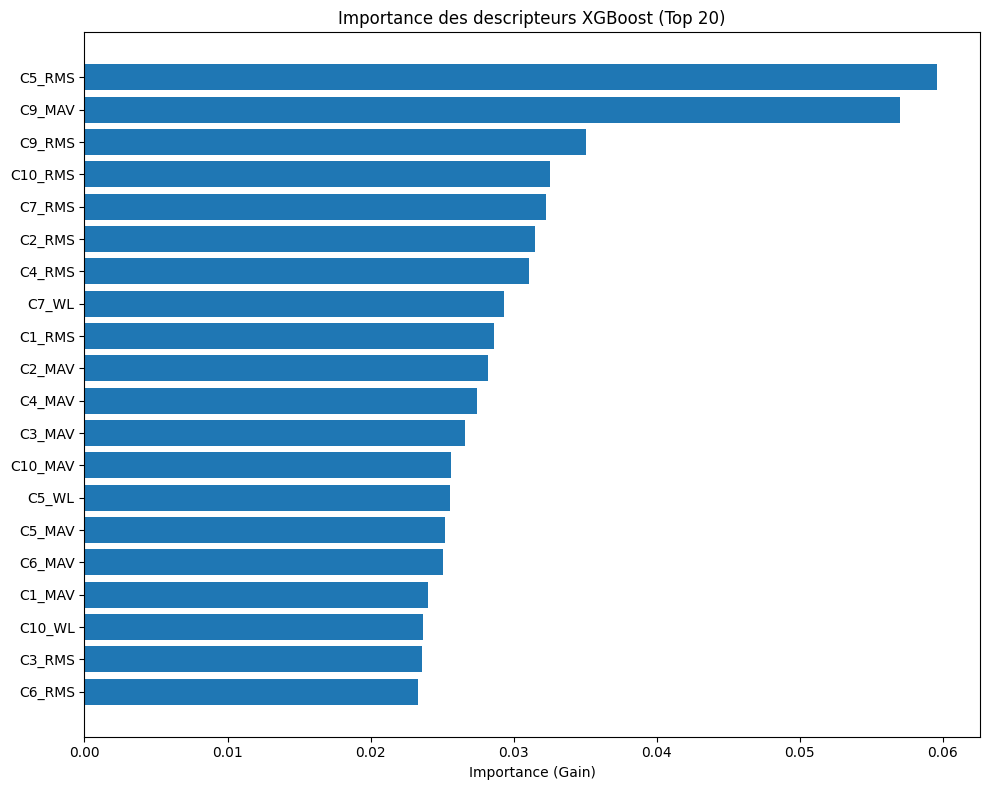

Graphique de performance par classe sauvegardé: class_performance.png


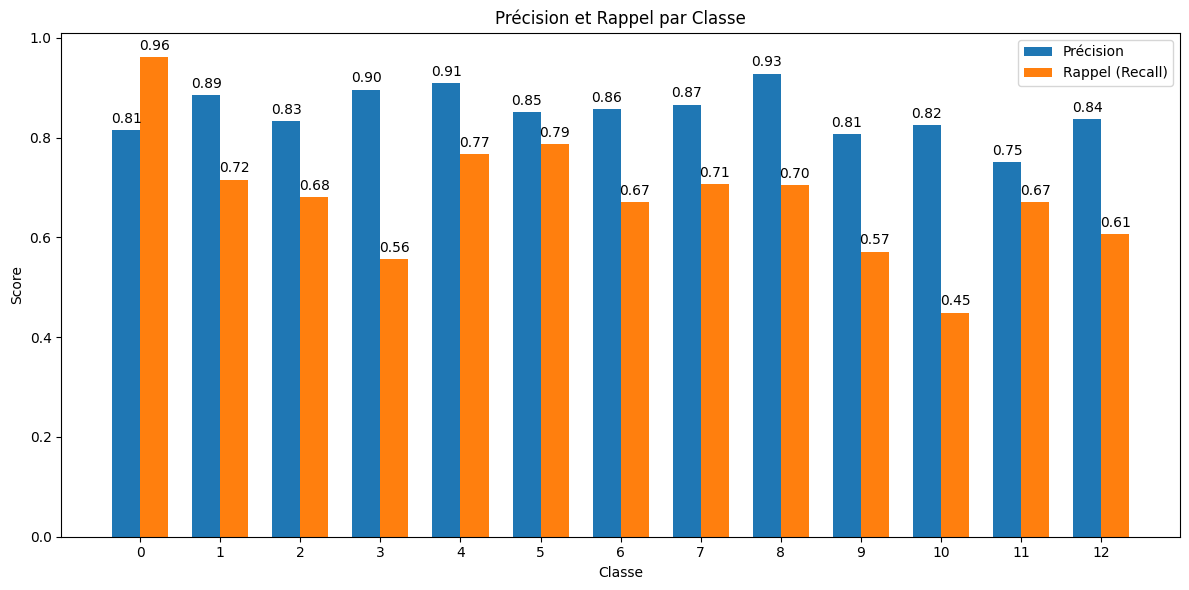


Validation croisée (5 plis)...


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Précision moyenne de la validation croisée (5 plis): 0.8264 ± 0.0055

Matrice de confusion cumulée de la validation croisée:
Matrice de confusion CV sauvegardée: confusion_matrix_cv.png


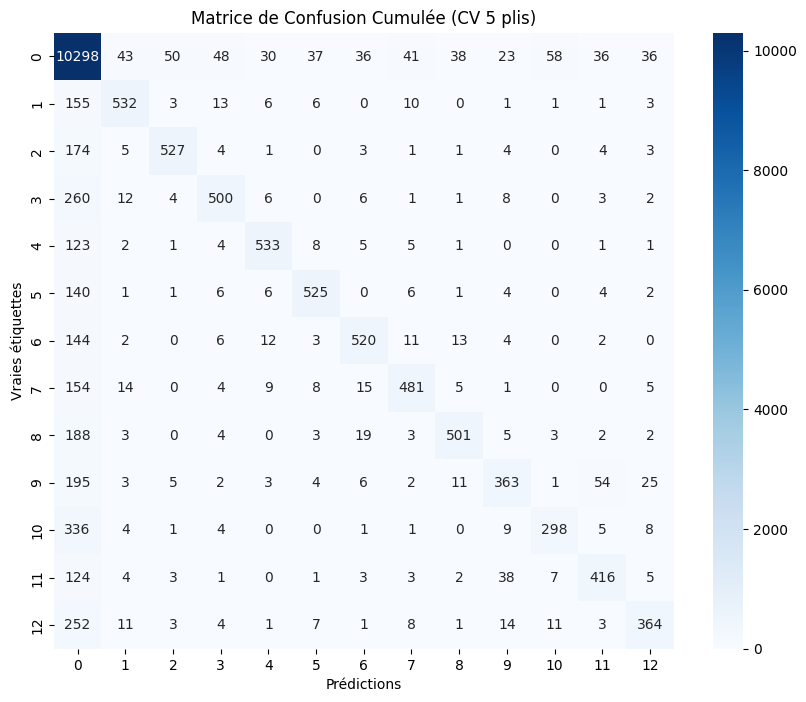


Modèle sauvegardé: emg_xgboost_model.json
Scaler sauvegardé: emg_scaler.pkl

--- Exemple de prédiction ---
Utilisation de la première fenêtre de features du premier sujet.
Classe prédite: 0

--- Fin du script ---


In [135]:
def main():
    print("--- Début du script de classification EMG avec XGBoost ---")
    data_path = '/kaggle/input/ninapro-dataset' 

    if not os.path.isdir(data_path):
        print(f"ERREUR: Le répertoire de données '{data_path}' n'existe pas.")
        print("Veuillez vérifier le chemin et la structure de vos données NinaPro.")
        return 

    WINDOW_SIZE = 200  
    OVERLAP = 100      
    TEST_SET_SIZE = 0.25 
    N_CV_SPLITS = 5     
    RANDOM_SEED = 42    
    SUBJECTS_TO_LOAD = None 

    all_emg_data, all_labels, subject_ids = load_multiple_subjects(data_path, subjects=SUBJECTS_TO_LOAD)

    if not all_emg_data:
        print("Aucune donnée n'a été chargée. Arrêt du script.")
        return

    all_features, all_segmented_labels, valid_subject_ids = preprocess_all_subjects(
        all_emg_data, all_labels, subject_ids, window_size=WINDOW_SIZE, overlap=OVERLAP
    )

    if not all_features:
        print("Aucune feature n'a été extraite après prétraitement. Arrêt du script.")
        del all_emg_data, all_labels
        return

    del all_emg_data, all_labels

    X_train, X_test, y_train, y_test, scaler = combine_data(
        all_features, all_segmented_labels, test_size=TEST_SET_SIZE, random_state=RANDOM_SEED
    )

    if X_train is None:
        print("Erreur lors de la combinaison des données. Arrêt du script.")
        return

    model, num_classes, label_map_inverse = train_xgboost_model(X_train, y_train)


    if X_test.shape[0] > 0:
        accuracy, conf_matrix, y_pred = evaluate_model(model, X_test, y_test, label_map_inverse, save_plots=True)
    else:
        print("\nAucun ensemble de test généré (test_size=0). Évaluation sur test set ignorée.")
        accuracy = None 


    try:
        X_combined_cv = np.vstack(all_features)
        y_combined_cv = np.hstack(all_segmented_labels)
        
        scaler_cv = StandardScaler()
        X_combined_scaled_cv = scaler_cv.fit_transform(X_combined_cv)

        cv_scores = cross_validate_model(X_combined_scaled_cv, y_combined_cv, n_splits=N_CV_SPLITS, random_state=RANDOM_SEED)

    except ValueError as e:
         print(f"Erreur lors de la préparation des données pour la validation croisée: {e}")
         cv_scores = []
    except Exception as e:
         print(f"Erreur inattendue pendant la validation croisée: {e}")
         cv_scores = []


    try:
        model_filename = 'emg_xgboost_model.json'
        model.save_model(model_filename)
        print(f"\nModèle sauvegardé: {model_filename}")

        scaler_filename = 'emg_scaler.pkl'
        joblib.dump(scaler, scaler_filename)
        print(f"Scaler sauvegardé: {scaler_filename}")

        if label_map_inverse:
             map_filename = 'label_map_inverse.pkl'
             joblib.dump(label_map_inverse, map_filename)
             print(f"Mapping d'étiquettes sauvegardé: {map_filename}")

    except Exception as e:
        print(f"Erreur lors de la sauvegarde du modèle ou du scaler: {e}")


    try:

        if 'all_features' in locals() and len(all_features) > 0 and all_features[0].shape[0] > 0:
            example_feature_vector = all_features[0][0:1, :] 

            example_feature_scaled = scaler.transform(example_feature_vector)

            prediction_mapped = model.predict(example_feature_scaled)

            if label_map_inverse:
                final_prediction = label_map_inverse[prediction_mapped[0]]
            else:
                final_prediction = prediction_mapped[0]

            print(f"\n--- Exemple de prédiction ---")
            print(f"Utilisation de la première fenêtre de features du premier sujet.")
            print(f"Classe prédite: {final_prediction}")
        else:
             print("\nImpossible de réaliser l'exemple de prédiction (pas de features disponibles).")


    except Exception as e:
        print(f"\nErreur lors de l'exemple de prédiction: {e}")


    print("\n--- Fin du script ---")

if __name__ == "__main__":
    main()